In [1]:
import json
import tkp.db
import tkp.config
import logging

import sys
import os
import struct
import numpy as np
import datetime

from scipy.stats import norm
import glob
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, EarthLocation,SkyCoord

import matplotlib
matplotlib.rcParams['text.usetex'] = False

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16
       }
matplotlib.rc('font', **font)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
import sys
import os
import glob


In [92]:
np.uint32(0x000000003B98F002)

999878658

In [39]:
CORR_HDR_MAGIC= np.uint32(0x000000003B98F002) # Magic number in raw corr visibilities.
A06_HDR_MAGIC = 0x4141525446414143
A12_HDR_MAGIC = 0x4141525446414144
A12_HDR_MAGIC= np.unint32(1081992285376802818)
LEN_HDR       = 512

# CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

In [40]:
class TransitVis (object):
    fname       = None # Name of visibility binary file.
    hdr         = None # record header
    fvis        = None # File pointer to binary file
    nrec        = None # Total number of records in this file
    nbline      = None # Total number of baselines in this file
    tfilestart  = None # First timestamp in the file
    tfileend    = None # Last timestamp in the file

    # Information extracted from an individual header
    magic       = None
    trec        = None # Current records start time
    sub         = None # Subband number
    nant        = None # Total number of dual-pol antennas in the array.
    npol        = None # Number of polarizations in the observation
    pol2rec     = None # Number of polarizations per record.
    nchan       = None # Number of channels in this file
    norigchan   = None # Number of original channels before preprocessing.
    dt          = None # Integration time per record

    # Per polarization information
    flagged_channels= None # Independent per pol.
    flagged_dipoles = None # Independent per pol.
    ateamflux   = None # Independent per pol.
    weights     = None
    nweight     = None

    # Frequency associated with channel or averaged set of channels.
    freq        = None 

    recbuf      = None # Complete, single record read from file
    vis         = None # Usable visibility array per record (both pols)
    tstamps     = None # List containing timestamps of all records in a file.

    deblev      = None # Debug level for messages.
    missrec     = None # Number of records thrown due to mismatched times.

    # Function abstraction for raw and calibrated visibilities
    read_rec    = None # Function object, initialised to the right read func.
    read_hdr    = None # Function object, initialised to the right read func.
    parse_hdr   = None # Function object, initialised to the right parse func.

    def __init__ (self, fname, nant=None, sub=None, nchan=None, npol=None, 
                    arrayconfig=None):
        """ Initialization of internal state corresponding to a visibility dump.
            Since the correlator raw visibility magic number doesn't distinguish
            between AARTFAAC-6 or AARTFAAC-12, and has no subband information, 
            this can be supplied to the init routine.
        """
        # Check if fname is a valid file, and open
        self.fname = fname
        self.fvis = open (self.fname, 'r')
        self.hdr = self.fvis.read (LEN_HDR)
        self.npol = 4;

#         import pdb; pdb.set_trace();
        self.magic, self.tfilestart, trec = struct.unpack ("<Qdd", self.hdr[0:24])
        print self.magic
#         if (self.magic == A06_HDR_MAGIC):
        self.nant     = 288 # 
#             self.read_rec = self.read_cal
        self.parse_hdr= self.parse_cal_hdr
        self.read_hdr = self.read_cal_hdr
        self.nchan    = 1 # See record description in parse_cal_hdr
        self.nweight  = (6*7)/2 # Per station weights
        self.pol2rec  = 1



        # New format, stores only upper triangle float ACM
        self.nbline  = self.nant*(self.nant+1)/2
        # 8 due to float complex.
        self.payload = self.nbline * self.nchan * self.pol2rec * 8
        self.recsize = self.payload + LEN_HDR
        fsize = os.path.getsize(fname)

        # NOTE: We need to read 2 recs for getting both polarizations from .cal
        if self.magic == A12_HDR_MAGIC or self.magic == A06_HDR_MAGIC:
            self.nrec = fsize/(self.recsize*2)
            print "A6"
        else:
            print "A12"
            self.nrec = fsize/(self.recsize) # each record has both pols in .vis
            # First record has a corrupted timestamp in a .vis file
            self.fvis.seek (self.recsize, 0) 
            self.hdr = self.fvis.read (LEN_HDR)
            self.magic, self.tfilestart, trec = struct.unpack ("<Qdd", 
                                                        self.hdr[0:24])
            

        self.fvis.seek (0)
        print "Nrecs", self.nrec
        print "size", fsize, self.recsize
        print self.tfilestart, trec
        self.dt = datetime.timedelta (seconds=(trec - self.tfilestart))# seconds
        self.tfilestart = datetime.datetime.utcfromtimestamp(self.tfilestart)
        
        # Find the last timestamp in a file.
        self.fvis.seek (0)
        self.fvis.seek ((self.nrec-1) * self.recsize)
        self.hdr = self.fvis.read (LEN_HDR)
        self.magic, self.tfileend, trec, self.sub, self.nant, pol, \
            self.norigchan, _, _, _, _, self.freq = self.parse_hdr (self.hdr)

        self.fvis.seek (0)


    def parse_cal_hdr(self, hdr):
        """
        Parse aartfaac header for calibrated data, independent per pol.
        Two pols are packed one after another, but with independent headers.
        struct output_header_t
        {
          uint64_t magic;                   ///< magic to determine header
          double start_time;                ///< start time (unix)
          double end_time;                  ///< end time (unix)
          int32_t subband;                  ///< lofar subband
          int32_t num_dipoles;              ///< number of dipoles (288 or 576)
          int32_t polarization;             ///< XX=0, YY=1
          int32_t num_channels;             ///< number of channels (<= 64)
          float ateam_flux[5];              ///< Ateam fluxes(CasA, CygA, Tau, Vir, Sun)
          std::bitset<5> ateam;             ///< Ateam active
          std::bitset<64> flagged_channels; ///< bitset of flagged channels (8 byte)
          std::bitset<576> flagged_dipoles; ///< bitset of flagged dipoles (72 byte)
          uint32_t weights[78];             ///< stationweights n*(n+1)/2, n in {6, 12}
          uint8_t pad[48];                  ///< 512 byte block
        };
        Record layout: The incoming channels in the raw visibilities from the
            correlator can be averaged in various combinations. The resulting
            averaged product gets its own record with an independent header.
            The record size for all records is the same, and corresponding data
            products (all records with the same channel integration, e.g.) will
            go into a single file. Other channel groups being averaged will go 
            into separate files.  
        """
        try:
            magic, t0, t1, sub, nant, pol, norigchan = struct.unpack("<Qddiiii",
                                                     hdr[0:40])
            ateamflux = struct.unpack("<fffff", hdr[40:60])
            ateam, flag_chans = struct.unpack("<QQ", hdr[60:76])
            flag_dips = struct.unpack ("<72b", hdr[76:148])
            weights = struct.unpack (("<%di" % self.nweight), 
                                    hdr[148:148+self.nweight*4]) # int weights
        except struct.error:
            print '### struct unpack error!'
            raise

        assert (magic == A06_HDR_MAGIC or magic == A12_HDR_MAGIC)
        # TODO: Examine the flagged channels to determine the actual frequency 
        # of the averaged channels. Currently return subband center.
        freq = sub * 195312.5 # Hz,
        
        return (magic, datetime.datetime.utcfromtimestamp(t0), datetime.datetime.utcfromtimestamp(t1), 
                sub, nant, pol, norigchan, ateamflux, flag_chans, flag_dips, weights, freq)

    # Return just the header, with metainformation extracted.
    # Faster than doing an actual read of the record payload.
    def read_cal_hdr (self, rec):
        
        assert (self.fvis)
        if (rec != None):
            raise NotImplemented

        # First pol.
        hdr = self.fvis.read (LEN_HDR)
        m, self.trec, t1, s, d, p, c, ateamflux, flag_chan, flag_dip, weights, \
                 freq = self.parse_hdr (hdr)
        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        self.fvis.seek (self.payload, 1)

        # Second polarization
        hdr = self.fvis.read (LEN_HDR)
        self.magic, trec, _, sub, self.nant, pol, \
            self.norigchan, ateamflux, flag_chan, flag_dip, weights, \
                    freq = self.parse_hdr (hdr)

        self.fvis.seek (self.payload, 1)
        # Check if both records correspond to the same trec
        # We can choose to keep only the single pol, or reject this record.
        if  (trec != self.trec):
            self.recbuf = 0
            self.fvis.seek (-self.recsize, 1) 
            print '## Mismatched times: pol %d tim: %s, pol %d tim: %s' \
                    % (p,self.trec, pol, trec)
            self.missrec = self.missrec + 1
            return -1

        self.ateamflux[p] = ateamflux
        self.flagged_dipoles[p] = flag_dip
        self.flagged_channels[p] = flag_chan

        return 1
    
    
def A12_checker(fname):
        LEN_HDR  = 512
        pol2rec  = 1
        nchan    = 3
        nant     = 576
        nbline  = nant*(nant+1)/2
        
        payload = nbline * nchan * pol2rec * 8
        recsize = payload + LEN_HDR
        
        fsize = os.path.getsize(fname)
        
        return fsize/(recsize*2)


In [26]:
struct.unpack?

In [8]:
ls /mnt/ais*/*.vis -larth

-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais006/SB318-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais005/SB311-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais004/SB301-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais005/SB304-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais004/SB298-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais006/SB321-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais004/SB294-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais006/SB315-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais007/SB328-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais005/SB308-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais002/SB281-202011112023-lba_outer.vis
-rw-r--r-- 1 asys asys 5.4G Nov 11 20:32 /mnt/ais002/S

In [102]:
fname = "/mnt/ais005/SB308-202011140717-lba_outer.vis"
fvis = open (fname, 'r')
hdr = fvis.read (LEN_HDR)

#         import pdb; pdb.set_trace();
print struct.unpack ("<Qdd", hdr[0:24])
# print struct.unpack ("Qdd", hdr[0:24])
# vis = TransitVis (fname)

(1081992285376802818, 1605338340.0, 1605338341.006633)


In [104]:
np.uint16(1605338341.006633)

34021

In [97]:
np.uint16()

956301312

In [ ]:
	uint32_t magic;
	uint16_t nrReceivers;
	uint8_t  nrPolarizations;
	uint8_t  correlationMode;
	double   startTime, endTime;
	uint32_t weights[78]; // Fixed-sized field, independent of #stations!
	uint32_t nrSamplesPerIntegration;
	uint16_t nrChannels;

In [91]:

print np.uint(0x3B98F002)
import ctypes
print np.uint32(1081992285376802818)


999878658
999878658


In [88]:
type(0x3B98F002)

int

In [38]:
import binascii
binascii.hexlify("0x3B98F002")

'30783342393846303032'

In [61]:
fname = "/mnt/ais004/SB301-202006100059-lba_outer.vis"

vis = TransitVis (fname)
print "start:", vis.tfilestart 

print "end:", Time(vis.tfilestart) + vis.nrec*u.s

Nrecs 460555
size 153567505408 333440
4.88708534924e+59 -1.01982582778e+50


OverflowError: Python int too large to convert to C long

In [4]:
fname = "/mnt/ais004/SB301-202006100059-lba_outer.vis"

tot_seconds = 0
for fname in glob.glob("/zfs/helios/filer0/mkuiack1//SB301*"):
#     print fname
    tot_seconds += A12_checker(fname)
print tot_seconds/60./60.


/mnt/ais006/SB237-202008122000-lba_inner.vis 5.175
/mnt/ais006/SB255-202008122000-lba_inner.vis 5.175
/mnt/ais006/SB238-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais006/SB238-202008122000-lba_inner.vis 5.175
/mnt/ais006/SB255-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais006/SB237-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais004/SB212-202008122000-lba_inner.vis 5.175
/mnt/ais004/SB195-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais004/SB195-202008122000-lba_inner.vis 5.17444444444
/mnt/ais004/SB212-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais004/SB194-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais004/SB194-202008122000-lba_inner.vis 5.175
/mnt/ais002/SB167-202008122000-lba_inner-A.vis 2.50527777778
/mnt/ais002/SB166-202008122000-lba_inner-A.vis 2.50527777778
/mnt/ais002/SB166-202008122000-lba_inner.vis 5.175
/mnt/ais002/SB167-202008122000-lba_inner.vis 5.17444444444
/mnt/ais005/SB235-202008122000-lba_inner-A.vis 2.50611111111
/mnt/ais005/SB236-202008122

In [ ]:
chan = 3
pols = 4
mystery = 2
Nrecs = 460555

Nrecs/(chan*pols*mystery)

In [52]:
153567505408/(333440*2)/(chan*pols)

19189

In [6]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')
position = SkyCoord(148.56*u.degree, 7.66*u.degree)

obs_times = pd.date_range(vis.tfilestart, periods=vis.nrec, freq='S', tz='utc')
altaz = position.transform_to(AltAz(obstime=[j for j in obs_times], location=CS002))
count = np.sum([(90. - altaz.alt.deg < 50.)])

print obs_times[(90. - altaz.alt.deg < 50.)][0]
print obs_times[(90. - altaz.alt.deg < 50.)][-1]

KeyboardInterrupt: 

In [5]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')
position = SkyCoord(148.56*u.degree, 7.66*u.degree)
position.transform_to(AltAz(obstime=pd.to_datetime("2019-09-01T10:30:59"), location=CS002))

<SkyCoord (AltAz: obstime=2019-09-01 10:30:59, location=(3826577.1095, 461022.900196, 5064892.758) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    ( 174.579475,  44.54347534)>

In [13]:
import astropy
astropy.__version__

u'2.0.9'

In [9]:
print(position.ra.hms, position.dec.dms)

(hms_tuple(h=9.0, m=54.0, s=14.400000000006088), dms_tuple(d=7.0, m=39.0, s=36.000000000000512))


In [10]:
f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*-*cal")
# f_list += glob.glob("/mnt/nex*/data/vis_archive/*/300*-20181*cal")


# f_list += glob.glob("/mnt/ais*/300*-20180[5,6,7,8,9]*cal")

# f_list = glob.glob("/mnt/ais*/300*-2019*cal")
# f_list += glob.glob("/mnt/nex*/data/vis_archive/*/300*-20190[4,5,6]*cal")
# f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*-20181*cal")
# f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*-201811*cal")
# f_list += glob.glob("/mnt/nex*/data/vis_archive/*/300*-201812*cal")
# f_list += glob.glob("/mnt/nex*/data/vis_archive/*/300*-2019*cal")

# f_list += glob.glob("/mnt/ais*/300*-201811*cal")
# f_list += glob.glob("/mnt/ais*/300*-201812*cal")
# f_list += glob.glob("/mnt/ais*/300*-*cal")

In [9]:
# f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*-*cal")
f_list = glob.glob("/mnt/ais*/281-*cal")

starts = []
n_records = []
ends = []
delta = datetime.timedelta()

for fname in f_list:
    try:
        vis = TransitVis (fname)
    except:
        print fname
        continue 

    starts.append(vis.tfilestart)
    n_records.append(vis.nrec)
    ends.append(Time(vis.tfilestart) + vis.nrec*u.s)
    delta += datetime.timedelta(seconds=vis.nrec)

Archive = pd.DataFrame({"filename":f_list, 
              "starttime":starts, 
              "length":n_records, "endtime":ends}).sort_values("length",ascending=False)

Archive["endtime"]= pd.DataFrame({"endtime":[x.to_datetime().strftime(format='%H:%M:%S %d %b %Y') for x in ends]})
Archive.endtime = pd.to_datetime(Archive.endtime)                                


In [5]:
np.sum(n_records)/60./60.

1144.2980555555555

In [13]:
Archive = pd.DataFrame({"filename":f_list, 
              "starttime":starts, 
              "length":n_records, "endtime":ends}).sort_values("length",ascending=False)

Archive["endtime"]= pd.DataFrame({"endtime":[x.to_datetime().strftime(format='%H:%M:%S %d %b %Y') for x in ends]})
Archive.endtime = pd.to_datetime(Archive.endtime)                                


In [102]:
print starts[0].dt
print ends[0]

AttributeError: 'datetime.datetime' object has no attribute 'dt'

In [10]:
f_list = glob.glob("/mnt/ais*/281-*cal")

tot_count = 0

obs_list = []
obs_count = []

CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')
position = SkyCoord(174.0125000*u.degree, 15.8539167*u.degree)

# 189.9166667    24.8970000
# 174.0125000    15.8539167
# 168.9083333    50.5033889


for i in range(len(f_list)):

    
    obs_times = pd.date_range(starts[i], periods=n_records[i], freq='S', tz='utc')
    altaz = position.transform_to(AltAz(obstime=[j for j in obs_times], location=CS002))
    count = np.sum([(90. - altaz.alt.deg < 50.)])
    
    
    print str(i)+" / " + str(len(f_list)), "\t", count, f_list[i]

    tot_count += count

    obs_list.append(f_list[i])
    obs_count.append(count)


pd.DataFrame({"obs_list":obs_list,"obs_count":obs_count}).to_csv("/home/kuiack/PSR_observations.csv")

0 / 57 	0 /mnt/ais002/281-202004011002.cal
1 / 57 	0 /mnt/ais002/281-202003221341.cal
2 / 57 	991 /mnt/ais002/281-202003240134.cal
3 / 57 	0 /mnt/ais002/281-202004061233.cal
4 / 57 	11688 /mnt/ais002/281-202003272220.cal
5 / 57 	0 /mnt/ais002/281-202003241119.cal
6 / 57 	5899 /mnt/ais002/281-202003222017.cal
7 / 57 	0 /mnt/ais002/281-202003241500.cal
8 / 57 	0 /mnt/ais002/281-202003270917.cal
9 / 57 	0 /mnt/ais002/281-202004071700.cal
10 / 57 	0 /mnt/ais002/281-202004080500.cal
11 / 57 	0 /mnt/ais002/281-202003300450.cal
12 / 57 	5605 /mnt/ais002/281-202004041330.cal
13 / 57 	0 /mnt/ais002/281-202004010600.cal
14 / 57 	6972 /mnt/ais002/281-202004052200.cal
15 / 57 	0 /mnt/ais002/281-202003281150.cal
16 / 57 	0 /mnt/ais002/281-202004051445.cal
17 / 57 	0 /mnt/ais002/281-202003231541.cal
18 / 57 	0 /mnt/ais002/281-202003231352.cal
19 / 57 	0 /mnt/ais002/281-202003301148.cal
20 / 57 	0 /mnt/ais002/281-202003240949.cal
21 / 57 	0 /mnt/ais002/281-202003270500.cal
22 / 57 	7866 /mnt/ais002/2

### 174.0125000    15.8539167
11688 /mnt/ais002/281-202003272220.cal
14125 /mnt/ais002/281-202004042104.cal
14067 /mnt/ais002/281-202003222200.cal


In [ ]:
obs_result = pd.DataFrame({"obs_list":obs_list,
                           "obs_count":obs_count,
                           "trap":np.zeros(len(obs_count), dtype=int)})

obs_result.to_csv("/home/kuiack/PSR_observations.csv")

In [10]:
obs_result = pd.read_csv("/home/kuiack/PSR_observations.csv")
obs_result[obs_result.trap == 0].sort_values("obs_count", ascending=False)

AttributeError: 'DataFrame' object has no attribute 'trap'

In [11]:
obs_result[obs_result.trap == 0].sort_values("obs_count", ascending=False)

AttributeError: 'DataFrame' object has no attribute 'trap'

In [4]:
f_list = glob.glob("/mnt/nex?/data/vis_archive/*/299*.cal")
# f_list += glob.glob("/mnt/ais*/299*.cal")



In [32]:
f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*.cal")
f_list += glob.glob("/mnt/ais*/300*cal")

print len(f_list) 

288


In [33]:
len(starts)

200

In [ ]:
delta = datetime.timedelta()

tot_recs = 0 

f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*.cal")
f_list += glob.glob("/mnt/ais*/300*cal")

# for obs in vis_archive[unique_obs_index]:
for fname in f_list:
    try:
        vis = TransitVis (fname)
    except: 
        print fname
        continue 
#     print "start:", vis.tfilestart 
#     print "alt end:", Time(vis.tfilestart) + vis.nrec*u.s
    
    delta += datetime.timedelta(seconds=vis.nrec)
    tot_recs += vis.nrec

print delta, tot_recs

In [ ]:
print "currently archived", delta.total_seconds()/60./60.

In [137]:
# TODO:

# get closest without going over foldername
# ls /mnt/nex*/data/vis_archive/* -d

# get closest without going over file in folder 
# # if not possible, time not covered 

# compare check time to start and end time
# # return true or false



In [4]:

vis_archive = np.array(glob.glob("/mnt/nex*/data/vis_archive/*/*.cal"))


In [5]:
obs_dates = pd.to_datetime([x[-16:-4] for x in vis_archive])

unique_obs, unique_obs_index = np.unique([x[-16:-4] for x in vis_archive],return_index=True)

In [6]:
unique_obs

array(['201608311510', '201609051647', '201609070340', '201611120632',
       '201611132000', '201611140501', '201611191013', '201611191812',
       '201702241630', '201702250130', '201702250800', '201702251405',
       '201702260116', '201702260800', '201702261405', '201702270116',
       '201702270350', '201702270700', '201702280900', '201702281001',
       '201702281102', '201702281203', '201702281405', '201703010116',
       '201703011110', '201703020800', '201703022359', '201703031600',
       '201703050200', '201703060100', '201703070355', '201703072025',
       '201703080100', '201703100123', '201703101604', '201703110628',
       '201703110800', '201703110901', '201703111002', '201703111103',
       '201703111204', '201703111305', '201703111406', '201703111507',
       '201703111608', '201703112033', '201703130428', '201703240901',
       '201703241002', '201703241103', '201703241204', '201703241305',
       '201703241406', '201703241507', '201703241610', '201703250100',
      

In [90]:
obs_dates[unique_obs_index]

DatetimeIndex(['2016-08-31 15:10:00', '2016-09-05 16:47:00',
               '2016-09-07 03:40:00', '2016-11-12 06:32:00',
               '2016-11-12 14:35:00', '2016-11-13 12:35:00',
               '2016-11-13 20:00:00', '2016-11-14 05:01:00',
               '2016-11-14 09:02:00', '2016-11-14 10:03:00',
               ...
               '2018-04-28 04:10:00', '2018-04-28 07:45:00',
               '2018-04-29 01:01:00', '2018-04-29 03:00:00',
               '2018-04-29 09:00:00', '2018-04-29 15:01:00',
               '2018-04-30 12:08:00', '2018-04-30 15:10:00',
               '2018-05-01 01:00:00', '2018-05-01 08:10:00'],
              dtype='datetime64[ns]', length=646, freq=None)

In [7]:
fermi = pd.read_csv('/home/kuiack/RECOVERED_FILES/kuiack/fermi_GRB_cat.csv')
swift = pd.read_csv("/home/kuiack/swift_GRB_cat.csv")

In [8]:
fermi["trigger_time"] = pd.to_datetime(fermi["trigger_time"])
swift["trigger_time"] = pd.to_datetime(swift["trigger_time"], errors='coerce')

In [48]:
swift.to_csv("/home/kuiack/swift_GRB_cat.csv", index=None)

In [9]:
swift.keys()
    

Index([u'GRB', u'Time [UT]', u'ra', u'dec', u'BAT T90 [sec]', u'trigger_time'], dtype='object')

In [99]:
fermi["trigger_time"].iloc[-1]

Timestamp('2014-03-11 21:14:35.646000')

 fermi GRB found in: /mnt/nex1/data/vis_archive/201804271004/317-201804271004.cal
	fermi time: 	2018-04-27 10:37:03.044000 	283.33 70.3 331.19143166 43.7664736372
		2018-04-27 10:04:25.199590
		2018-04-27 17:11:09.199590
 fermi GRB found in: /mnt/nex1/data/vis_archive/201804261245/318-201804261245.cal
	fermi time: 	2018-04-26 13:11:00.846000 	202.41 58.17 20.2988358183 65.1101806031
		2018-04-26 12:45:10.442911
		2018-04-26 20:03:05.442911
 fermi GRB found in: /mnt/nex1/data/vis_archive/201804230020/318-201804230020.cal
	fermi time: 	2018-04-23 00:47:03.657000 	208.68 9.84 208.87580711 46.3021125134
		2018-04-23 00:20:19.822249
		2018-04-23 02:28:07.822249
 fermi GRB found in: /mnt/nex1/data/vis_archive/201803110000/345-201803110000.cal
	fermi time: 	2018-03-11 01:45:53.301000 	53.95 -35.77 294.50675753 151.697399311
		2018-03-11 00:00:11.903217
		2018-03-11 11:53:14.903217
 fermi GRB found in: /mnt/nex0/data/vis_archive/201801130322/228-201801130322.cal
	fermi time: 	2018-01-13 10:02:

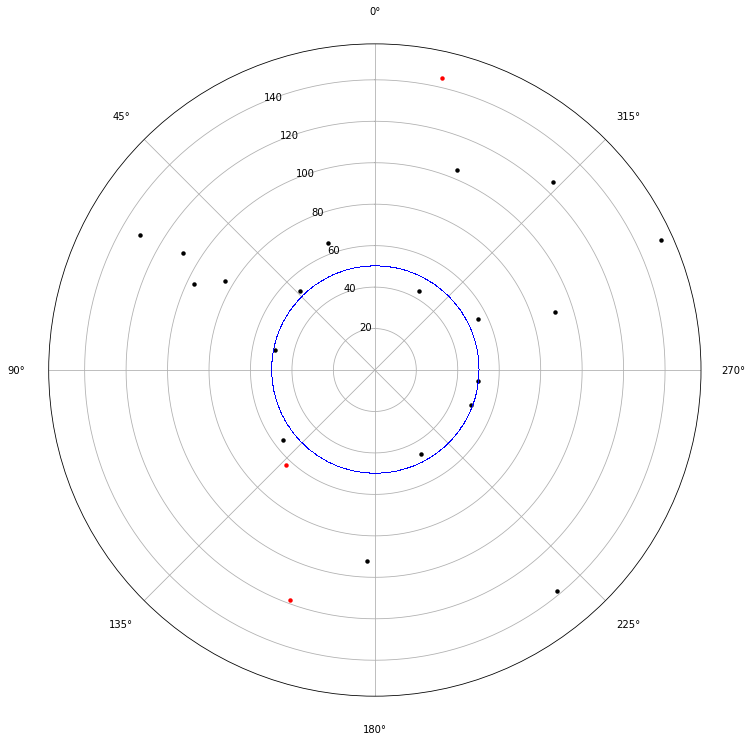

In [88]:
plt.figure(figsize=(12,12))
ax = plt.subplot(projection='polar')

for i in range(len(fermi["trigger_time"])):
#     print "fermi time:", fermi["trigger_time"].iloc[i]
    try:
        fermi_time = fermi["trigger_time"].iloc[i]
#     print obs_dates[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1]
        vis = TransitVis (vis_archive[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1])
    
        position = SkyCoord(fermi["ra"].iloc[i]*u.degree, fermi["dec"].iloc[i]*u.degree)
        altaz = position.transform_to(AltAz(obstime=fermi["trigger_time"].iloc[i], location=CS002))
    
        if fermi["trigger_time"].iloc[i] > vis.tfilestart and  fermi["trigger_time"].iloc[i] < vis.tfilestart + datetime.timedelta(seconds=vis.nrec):
            print " fermi GRB found in:",vis_archive[unique_obs_index][obs_dates[unique_obs_index] < fermi["trigger_time"].iloc[i]][-1]
            print '\t', "fermi time:",'\t', fermi["trigger_time"].iloc[i], '\t', fermi["ra"].iloc[i], fermi["dec"].iloc[i], altaz.az.deg, 90.-altaz.alt.deg
            print '\t','\t', vis.tfilestart
            print '\t','\t', vis.tfilestart + datetime.timedelta(seconds=vis.nrec)
            
            
            plt.scatter(altaz.az.rad,90-altaz.alt.deg,c="k", lw=0, s=20 )
            
# plt.plot(altaz.az.rad[:1000],np.abs(90-altaz.alt.deg)[:1000], ".", c=col_tup[:1000], lw=0 )

            
    except IndexError:
        continue 

for i in range(len(swift["trigger_time"])):
    try:
        swift_time = swift["trigger_time"].iloc[i]
        vis = TransitVis (vis_archive[unique_obs_index][obs_dates[unique_obs_index] < swift["trigger_time"].iloc[i]][-1])
    
        position = SkyCoord(swift["ra"].iloc[i]*u.degree, swift["dec"].iloc[i]*u.degree)
        altaz = position.transform_to(AltAz(obstime=swift["trigger_time"].iloc[i], location=CS002))
    
        if swift["trigger_time"].iloc[i] > vis.tfilestart and  swift["trigger_time"].iloc[i] < vis.tfilestart + datetime.timedelta(seconds=vis.nrec):
            print " swift GRB found in:",vis_archive[unique_obs_index][obs_dates[unique_obs_index] < swift["trigger_time"].iloc[i]][-1]
            print '\t', "swift time:",'\t', swift["trigger_time"].iloc[i], '\t', swift["ra"].iloc[i], swift["dec"].iloc[i], altaz.az.deg, 90.-altaz.alt.deg
            print '\t','\t', vis.tfilestart
            print '\t','\t', vis.tfilestart + datetime.timedelta(seconds=vis.nrec)
            
            
            plt.scatter(altaz.az.rad,90-altaz.alt.deg,c="r", lw=0, s=20 )
            
# plt.plot(altaz.az.rad[:1000],np.abs(90-altaz.alt.deg)[:1000], ".", c=col_tup[:1000], lw=0 )

            
    except IndexError:
        continue 
        
        
plt.plot(np.linspace(0,2*np.pi, 1000),50.*np.ones(1000),",",c="b")
ax.set_theta_zero_location("N")


In [13]:
len(fermi)

1000

211.979034563 57.4321619406


In [41]:
delta.total_seconds()/(60*60)

55.318333333333335

In [23]:


print vis.nrec
print Time(vis.tfilestart) + vis.nrec*u.s


13042
2017-02-25 05:07:32.068455


In [47]:


delta = dt.timedelta()

In [63]:
delta + dt.timedelta(seconds=vis.nrec)

datetime.timedelta(0, 13042)

In [62]:
vis.tfilestart+ dt.timedelta(seconds=vis.nrec)

datetime.datetime(2017, 2, 25, 5, 7, 32, 68455)

In [75]:
ls /home/kuiack/RECOVERED_FILES/kuiack/


201702_data.pickle.pkl          full_spectrum_file_rms_lst.csv
201702_data.pickle.pkl.v1       full_spectrum_file_rms_lst.csv.v1
201702_data.pickle.pkl.v2       full_spectrum_file_rms_lst.csv.v2
295-201802091329.cal_XX.txt     image_filter.ipynb
295-201802091329.cal_XX.txt.v1  image_filter.ipynb.v1
295-201802091329.cal_XX.txt.v2  image_filter.ipynb.v2
295-201802091329.cal_YY.txt     make_reference_catalogue.ipynb
295-201802091329.cal_YY.txt.v1  make_reference_catalogue.ipynb.v1
295-201802091329.cal_YY.txt.v2  make_reference_catalogue.ipynb.v2
350-201711071552.cal_XX.txt     mkuiack/
350-201711071552.cal_XX.txt.v1  monet_img.log
350-201711071552.cal_XX.txt.v2  monet_img.log.v1
350-201711071552.cal_YY.txt     monet_img.log.v2
350-201711071552.cal_YY.txt.v1  newtrap/
350-201711071552.cal_YY.txt.v2  prototype_atv_visualisation.ipynb
357-201711071810.cal_YY.txt     prototype_atv_visualisation.ipynb.v1
357-201711071810.cal_YY.txt.v1  prototype_atv_visualisation.ipynb.v2
357-201711071810.cal_

In [21]:
fname = "/mnt/nex0/data/vis_archive/201710061401/302-201710061401.cal"

vis = TransitVis (fname)

#     print "start:", vis.tfilestart 
#     print "alt end:", Time(vis.tfilestart) + vis.nrec*u.s

print datetime.timedelta(seconds=vis.nrec).seconds /60., "minutes"

    
# print delta

26.8166666667 minutes


In [5]:
vis = TransitVis ("/mnt/ais002/295-201901130000.cal")
print vis.tfilestart
print vis.tfileend
print Time(vis.tfilestart) + vis.nrec*u.s

2019-01-13 00:02:00
2019-01-13 00:23:20.437125
2019-01-13 00:44:25


2017-08-23 04:45:31.144704
2017-08-23 05:52:13.517353
2017-08-23 06:58:05.144704


In [36]:
position = SkyCoord(8*u.hour, +20.0*u.degree)
altaz = position.transform_to(AltAz(obstime="2017-06-08T11:01:16", location=CS002))
print altaz.az.deg, 90.-altaz.alt.deg

109.982566281 51.052101422


## Get all AARTFAAC databases

In [7]:
def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

In [8]:
import sys
# import database username/password/etc.
sys.path.append('/home/kuiack')
from database_info import *
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING


In [9]:
dbname = "ASr_201611140501"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

# print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

db = tkp.db.Database(engine=engine, host=host, port=port,
                     user=user, password=password, database=dbname)

db.connect()
session = db.Session()

transients_query = """
    SELECT datname from pg_database
    """

databases = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

db._configured = False
del db, session

print len(AS_databases)

89


In [69]:
f_list = glob.glob("/mnt/nex*/data/vis_archive/*/300*-*cal")


starts = [] 
n_records = []
ends = [] 
delta = datetime.timedelta()

for fname in f_list:
    try:
        vis = TransitVis (fname)
    except:
        print fname
        continue 

    starts.append(vis.tfilestart)
    n_records.append(vis.nrec)
    ends.append(Time(vis.tfilestart) + vis.nrec*u.s)
    delta += datetime.timedelta(seconds=vis.nrec)

Archive = pd.DataFrame({"filename":f_list, 
              "starttime":starts, 
              "length":n_records, "endtime":ends}).sort_values("length",ascending=False)

Archive["endtime"]= pd.DataFrame({"endtime":[x.to_datetime().strftime(format='%H:%M:%S %d %b %Y') for x in ends]})
Archive.endtime = pd.to_datetime(Archive.endtime)                                


## Get first timestamp

In [91]:
delta = datetime.timedelta()
DBtimes = pd.DataFrame({"taustart_ts":[]})

for AS_db in AS_databases:
    
    dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

#     print "database name: ",  AS_db
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        (SELECT taustart_ts 
        FROM image)
        """
    
#     transients_query = """
#         (SELECT taustart_ts 
#         FROM image ORDER BY taustart_ts ASC LIMIT 4)
#         UNION ALL
#         (SELECT taustart_ts 
#         FROM image ORDER BY taustart_ts DESC LIMIT 4)
#         """

    DBtimes = pd.concat([DBtimes,
                       pd.DataFrame(run_query(transients_query, AS_db, dataset, 
                                              engine, host, port, user, password))])

    db._configured = False
    del db, session

In [171]:
db._configured = False
del db, session

In [25]:

Archive[([x not in DBtimes.taustart_ts.dt.round("1d").values \
 for x in Archive.starttime.dt.round("1d").values]) or ([x not in DBtimes.taustart_ts.dt.round("1d").values \
 for x in Archive.endtime.dt.round("1d").values])].sort_values("length", ascending = False)


,endtime,filename,length,starttime
299,2019-05-29 14:46:48,/mnt/nex1/data/vis_archive/201905290920/300-20...,19488,2019-05-29 09:22:00.000000
274,2019-02-25 03:39:29,/mnt/nex1/data/vis_archive/201902242216/300-20...,19289,2019-02-24 22:18:00.000000
166,2019-09-01 23:56:59,/mnt/nex0/data/vis_archive/201909011855/300-20...,17999,2019-09-01 18:57:00.000000
188,2019-02-24 21:53:05,/mnt/nex0/data/vis_archive/201902241654/300-20...,17825,2019-02-24 16:56:00.000000
25,2018-04-19 05:57:01,/mnt/nex2/data/vis_archive/201804190100/300-20...,17807,2018-04-19 01:00:14.074030
225,2018-04-09 02:57:00,/mnt/nex1/data/vis_archive/201804082200/300-20...,17806,2018-04-08 22:00:14.496497
319,2018-04-24 19:04:00,/mnt/nex1/data/vis_archive/201804241407/300-20...,17799,2018-04-24 14:07:21.787950
305,2018-03-20 19:27:00,/mnt/nex1/data/vis_archive/201803201430/300-20...,17791,2018-03-20 14:30:29.332685
330,2018-04-04 19:42:06,/mnt/nex1/data/vis_archive/201804041500/300-20...,16898,2018-04-04 15:00:28.481961
63,2018-03-28 00:55:06,/mnt/nex2/data/vis_archive/201803272014/300-20...,16842,2018-03-27 20:14:24.917576


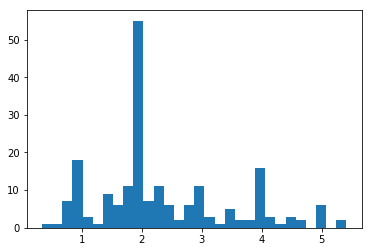

In [26]:
_hist = plt.hist(Archive[([x not in DBtimes.taustart_ts.dt.round("1d").values \
 for x in Archive.starttime.dt.round("1d").values] ) or ([x not in DBtimes.taustart_ts.dt.round("1d").values \
 for x in Archive.endtime.dt.round("1d").values])].length/3600., bins=30 )

In [167]:
np.abs(Archive.endtime.dt.round("10min").values[0] - 
       times.taustart_ts.dt.round("1min").values[0]) > np.timedelta64(10,"m")



True

([<matplotlib.axis.YTick at 0x7fd19a63fa90>],
 <a list of 1 Text yticklabel objects>)

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


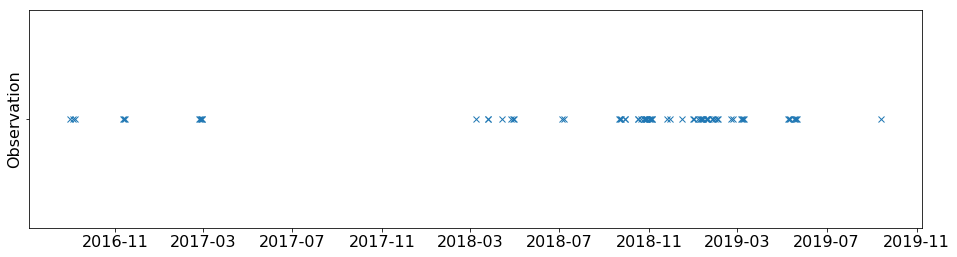

In [34]:
dates = np.unique([pd.to_datetime(x.split("_")[1]).date() for x in AS_databases])
ones = np.ones(len(dates))
plt.figure(figsize=(16,4))
plt.plot(dates,  ones,  "x", ) 
plt.yticks([1],["Observation"], rotation=90, va="center")

In [60]:


delta = datetime.timedelta()
all_time = []

for AS_db in AS_databases:
    
    dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

#     print "database name: ",  AS_db
    logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=AS_db)

    db.connect()
    session = db.Session()

    transients_query = """
        SELECT taustart_ts FROM image
        """

    times = pd.DataFrame(run_query(transients_query, AS_db, dataset, engine, host, port, user, password))
#     roundtime = [i for i in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))]
    try: 
        obs_len = datetime.timedelta(seconds=len(np.unique(times.taustart_ts.dt.round("1s"))))
        delta += obs_len
        all_time.append([x.hour for x in pd.to_datetime(np.unique(times.taustart_ts.dt.round("1s")))])
        db._configured = False
        del db, session
        
    except AttributeError:
        print AS_db
        db._configured = False
        del db, session

#     print "\t", obs_len



In [61]:
print "Total currently archived", delta.total_seconds()/60./60.

Total currently archived 575.460277778


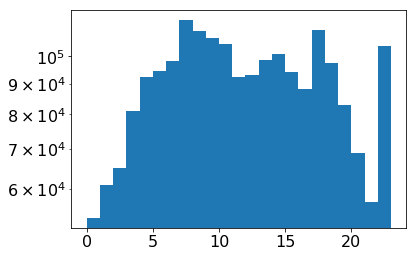

In [71]:
plt.figure()
_histout = plt.hist(np.array([y for x in all_time for y in x]), log=True,
         bins=np.linspace(0,23,24))

Text(0,0.5,'Number of times observed')

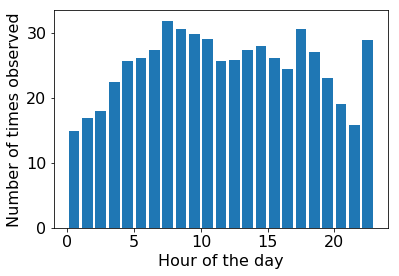

In [81]:
plt.bar((_histout[1][1:]+_histout[1][:-1])/2.,_histout[0]/3600.)
plt.xlabel("Hour of the day")
plt.ylabel("Number of times observed")

In [38]:
# bins = pd.date_range(np.min(DBtimes.taustart_ts.dt.round("1d").values), 
#                      np.max(DBtimes.taustart_ts.dt.round("1d").values), 
#                     freq="1m")
np.unique(DBtimes.taustart_ts.dt.month, return_counts=True, return_index=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([35, 10, 46, 54, 64, 62, 50, 55,  0,  4,  7, 36]),
 array([13, 16,  9,  4,  9,  1,  2,  1, 11, 10, 10,  2]))

In [55]:
s= DBtimes.taustart_ts
pd.concat([pd.DataFrame(bins),x ])

,0,month,unique days,year
0,2016-09-30,NaN,NaN,NaN
1,2016-10-31,NaN,NaN,NaN
2,2016-11-30,NaN,NaN,NaN
3,2016-12-31,NaN,NaN,NaN
4,2017-01-31,NaN,NaN,NaN
5,2017-02-28,NaN,NaN,NaN
6,2017-03-31,NaN,NaN,NaN
7,2017-04-30,NaN,NaN,NaN
8,2017-05-31,NaN,NaN,NaN
9,2017-06-30,NaN,NaN,NaN


In [67]:
[str(x.iloc[i]["year"])+'-'+str(x.iloc[i]["month"])+": "+str(x.iloc[i]["unique days"])  for i in range(len(x))]

['2016-8: 1',
 '2016-9: 2',
 '2016-11: 3',
 '2017-2: 9',
 '2018-3: 4',
 '2018-4: 4',
 '2018-6: 1',
 '2018-7: 2',
 '2018-9: 8',
 '2018-10: 9',
 '2018-11: 7',
 '2018-12: 2',
 '2019-1: 13',
 '2019-2: 7',
 '2019-3: 5',
 '2019-5: 9',
 '2019-9: 1']

In [76]:
Arch = pd.DataFrame( {"month":Archive.starttime.dt.month,"year":Archive.starttime.dt.year})

In [141]:
s_analysed = DBtimes.taustart_ts

analysed =  pd.DataFrame(s_analysed.groupby([s_analysed.dt.year, 
                                 s_analysed.dt.month])
                         .nunique()
                         .rename_axis(['year', 'month'])
                         .reset_index(name='unique days'))



In [142]:
analysed

,year,month,unique days
0,2016,8,9228
1,2016,9,32068
2,2016,11,93901
3,2017,2,114293
4,2017,6,1
5,2017,7,2
6,2018,2,2
7,2018,3,99306
8,2018,4,153436
9,2018,6,1


In [143]:
# TraP database distribution. (hours per month)

Ana = analysed[analysed["unique days"] > 3 ]


[str(Ana.iloc[i]["year"]) +\
 '-'+str(Ana.iloc[i]["month"]) +\
 " & "+str(round(Ana.iloc[i]["unique days"]/3600.,1)) for i in range(len(Ana))]


['2016-8 & 2.6',
 '2016-9 & 8.9',
 '2016-11 & 26.1',
 '2017-2 & 31.7',
 '2018-3 & 27.6',
 '2018-4 & 42.6',
 '2018-7 & 24.6',
 '2018-9 & 25.1',
 '2018-10 & 72.0',
 '2018-11 & 58.2',
 '2018-12 & 15.4',
 '2019-1 & 113.0',
 '2019-2 & 38.3',
 '2019-3 & 31.8',
 '2019-5 & 64.6',
 '2019-9 & 6.2']

In [90]:
s_full = Archive.starttime
pd.DataFrame(s_full.groupby([s_full.dt.year, 
                             s_full.dt.month])
  .nunique()
  .rename_axis(['year', 'month'])
  .reset_index(name='unique days'))

,year,month,unique days
0,2016,8,1
1,2016,9,2
2,2016,11,3
3,2017,2,8
4,2018,3,20
5,2018,4,43
6,2018,5,1
7,2018,7,6
8,2018,9,8
9,2018,10,26


In [125]:
# Archive observation distribution 

Arch = pd.DataFrame(Archive['length'].groupby([s_full.dt.year, 
                             s_full.dt.month]).sum()
                 .rename_axis(['year', 'month'])
                 .reset_index(name='length'))

[str(Arch.iloc[i]["year"])+\
 '-'+str(Arch.iloc[i]["month"])+\
 ": "+str(round(Arch.iloc[i]["length"]/3600.,1))  for i in range(len(Arch))]


['2016-8: 2.5',
 '2016-9: 8.9',
 '2016-11: 14.8',
 '2017-2: 30.5',
 '2018-3: 85.4',
 '2018-4: 156.7',
 '2018-5: 2.5',
 '2018-7: 32.2',
 '2018-9: 27.0',
 '2018-10: 82.3',
 '2018-11: 59.8',
 '2018-12: 30.1',
 '2019-1: 114.4',
 '2019-2: 114.8',
 '2019-3: 105.6',
 '2019-4: 43.9',
 '2019-5: 84.9',
 '2019-7: 29.1',
 '2019-9: 119.0']